In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/MyDrive/MachineLearning/CNN/cifar-10-batches-py.zip'

Archive:  /content/gdrive/MyDrive/MachineLearning/CNN/cifar-10-batches-py.zip
   creating: cifar-10-batches-py/
  inflating: cifar-10-batches-py/batches.meta  
  inflating: cifar-10-batches-py/data_batch_1  
  inflating: cifar-10-batches-py/data_batch_2  
  inflating: cifar-10-batches-py/data_batch_3  
  inflating: cifar-10-batches-py/data_batch_4  
  inflating: cifar-10-batches-py/data_batch_5  
 extracting: cifar-10-batches-py/readme.html  
  inflating: cifar-10-batches-py/test_batch  


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tensorflow.python.keras import backend as K
from tensorflow.keras import layers
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import math
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
cifar10_dir= 'cifar-10-batches-py'

In [ ]:
# # Function to load a batch into memory
# def load_batch(data_dir, batch_id):
#     with open(os.path.join(cifar10_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
#         batch = pickle.load(file, encoding='latin1')
#     feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
#     lbls = batch['labels']
#     return feats, lbls

In [ ]:
def load_batch(fpath):
    import pickle
    with open(fpath, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        data = d[b'data']
        labels = d[b'labels']
        data = data.reshape(data.shape[0], 3, 32, 32)
        return data, labels

In [ ]:
def load_data(path):
    """Loads CIFAR10 dataset from the local directory.

    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
         y_train[(i - 1) * 10000:i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)


In [ ]:
os.chdir("C:/Users/Asus-FPT/OneDrive - The University of Technology/Documents/. learning/Coding/Hoc may va UD/Cifar10_Train")

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data(cifar10_dir)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


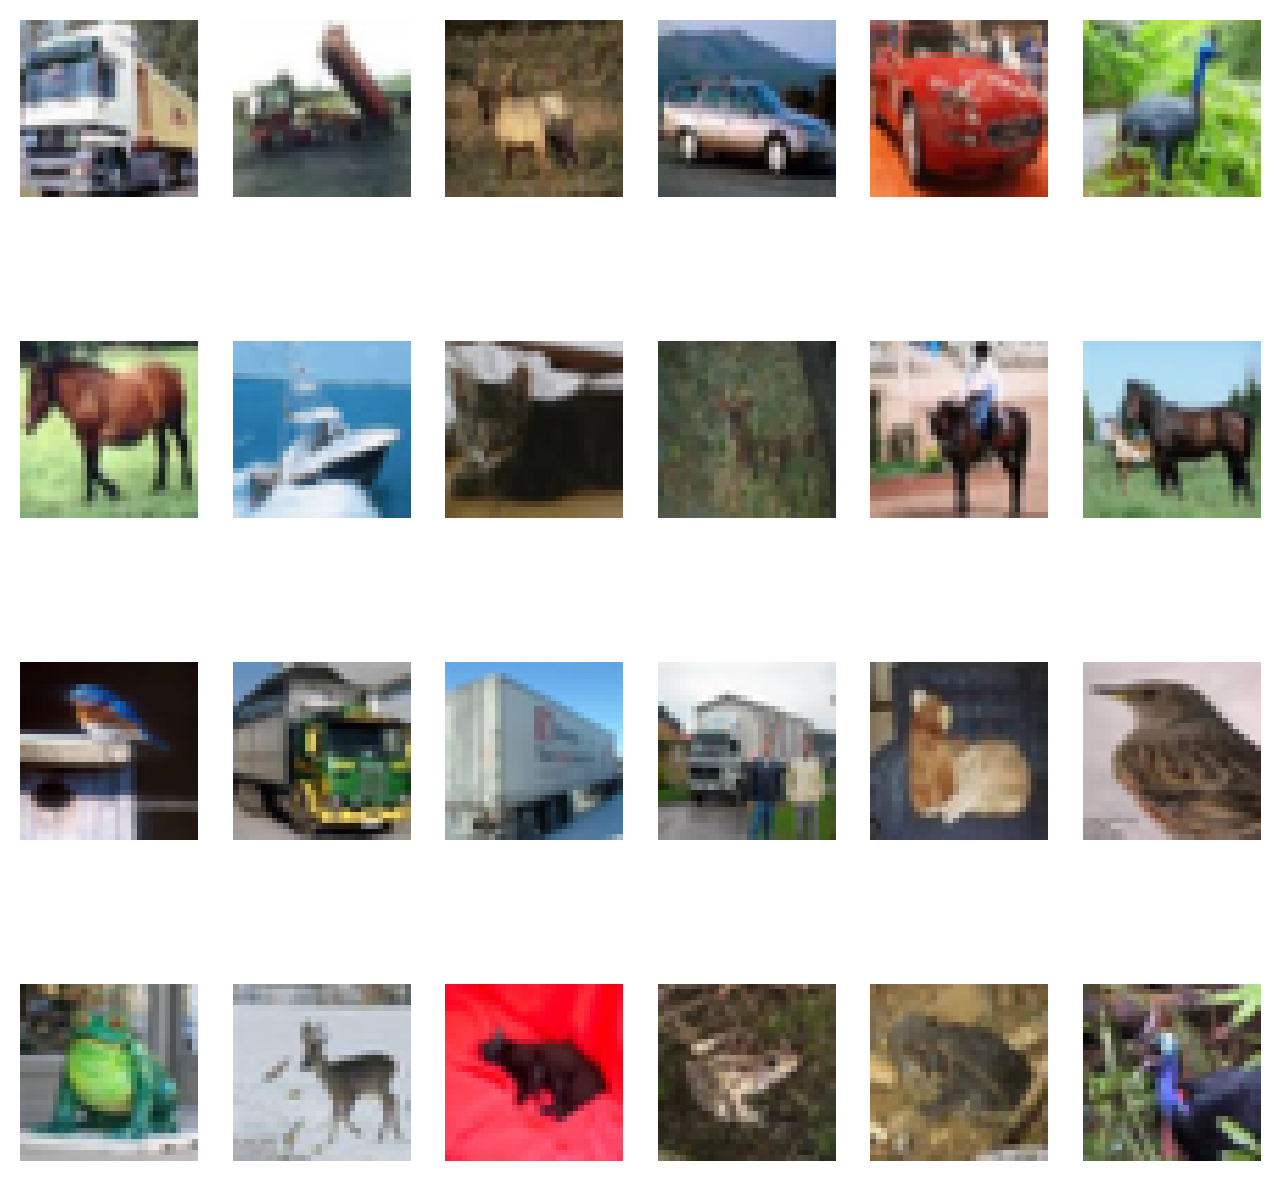

In [ ]:
fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 4
for i in range(1, columns*rows +1):
    img = x_train[i]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

PREPROCESSING

In [ ]:
print(x_train.max())
print(x_test.max())

255
255


In [ ]:
padding = 4
image_size = 32
target_size = image_size + padding*2

In [ ]:
def get_dataset():
    """Download, parse and process a dataset to unit scale and one-hot labels."""
    (train_images, train_labels), (test_images, test_labels) = load_data(cifar10_dir)

    # Normalize pixel values to be between 0 and 1
    train_images, test_images = train_images/255.0, test_images/255.0

    # One-hot labels
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)
    return train_images, train_labels, test_images, test_labels

def get_mean_and_std(images):
    """Compute the mean and std value of dataset."""
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std

def normalize(images, mean, std):
    """Normalize data with mean and std."""
    return (images - mean) / std

def dataset_generator(images, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(_augment_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(len(images)).batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def _one_hot(train_labels, num_classes, dtype=np.float32):
    """Create a one-hot encoding of labels of size num_classes."""
    return np.array(train_labels == np.arange(num_classes), dtype)

def _augment_fn(images, labels):
    images = tf.image.pad_to_bounding_box(images, padding, padding, target_size, target_size)
    images = tf.image.random_crop(images, (image_size, image_size, 3))
    images = tf.image.random_flip_left_right(images)
    return images, labels

# AlexNet

In [ ]:
class AlexNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = layers.Conv2D(96, kernel_size=11, strides=4, padding='same', activation='relu')
        self.max_pool2d1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.conv2 = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')
        self.max_pool2d2 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.conv3 = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')
        self.conv4 = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')
        self.conv5 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.max_pool2d3 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(4096, activation='relu')
        self.dropout1 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(4096, activation='relu')
        self.dropout2 = layers.Dropout(0.5)
        self.fc3 = layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        out = self.max_pool2d1(self.conv1(x))
        out = self.max_pool2d2(self.conv2(out))
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.max_pool2d3(self.conv5(out))
        out = self.flatten(out)
        out = self.dropout1(self.fc1(out))
        out = self.dropout2(self.fc2(out))
        out = self.fc3(out)
        return out

Model Class

In [ ]:
class Model():
    def __init__(self, model_type, lr, decay_steps, num_classes=10):
        if 'alexnet' in model_type:
            self.model = AlexNet(num_classes)
        elif 'vgg' in model_type:
            self.model = VGG(model_type, num_classes)
        elif 'densenet' in model_type:
            self.model = DenseNet(model_type, num_classes)
        else:
            sys.exit(ValueError("{:s} is currently not supported.".format(model_type)))

        self.loss_object = tf.keras.losses.CategoricalCrossentropy()
        learning_rate_fn = tf.keras.experimental.CosineDecay(lr, decay_steps=decay_steps)
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
        self.weight_decay = 5e-4

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            # Cross-entropy loss
            ce_loss = self.loss_object(labels, predictions)
            # L2 loss(weight decay)
            l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in self.model.trainable_variables])
            loss = ce_loss + l2_loss*self.weight_decay

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)

    @tf.function
    def test_step(self, images, labels):
        predictions = self.model(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)

    def train(self, model, train_ds, test_ds, epoch, resume):
        best_acc = tf.Variable(0.0)
        curr_epoch = tf.Variable(0)  # start from epoch 0 or last checkpoint epoch
        ckpt_path = './checkpoints/{:s}/'.format(model)
        ckpt = tf.train.Checkpoint(curr_epoch=curr_epoch, best_acc=best_acc,
                                   optimizer=self.optimizer, model=self.model)
        manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=1)

        if resume:
            # Load checkpoint.
            print('==> Resuming from checkpoint...')
            assert os.path.isdir(ckpt_path), 'Error: no checkpoint directory found!'

            # Restore the weights
            ckpt.restore(manager.latest_checkpoint)

        for e in tqdm(range(int(curr_epoch), epoch)):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for images, labels in test_ds:
                self.test_step(images, labels)

            template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
            print (template.format(e+1,
                                   self.train_loss.result(),
                                   self.train_accuracy.result()*100,
                                   self.test_loss.result(),
                                   self.test_accuracy.result()*100))

            # Save checkpoint
            if self.test_accuracy.result() > best_acc:
                print('Saving...')
                if not os.path.isdir('./checkpoints/'):
                    os.mkdir('./checkpoints/')
                if not os.path.isdir(ckpt_path):
                    os.mkdir(ckpt_path)
                best_acc.assign(self.test_accuracy.result())
                curr_epoch.assign(e+1)
                manager.save()

    def predict(self, model, pred_ds, best):
        if best:
            ckpt_path = './checkpoints/{:s}/'.format(model)
            ckpt = tf.train.Checkpoint(model=self.model)
            manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=1)

            # Load checkpoint
            print('==> Resuming from checkpoint...')
            assert os.path.isdir(ckpt_path), 'Error: no checkpoint directory found!'
            ckpt.restore(manager.latest_checkpoint)

        self.test_accuracy.reset_states()
        for images, labels in pred_ds:
            self.test_step(images, labels)
        print ('Prediction Accuracy: {:.2f}%'.format(self.test_accuracy.result()*100))

    def get_predictions_and_labels(self, dataset):
        y_true = []
        y_pred = []
        for images, labels in dataset:
            predictions = self.model.predict(images)
            y_true.extend(np.argmax(labels.numpy(), axis=1))
            y_pred.extend(np.argmax(predictions, axis=1))
        return y_true, y_pred

    def plot_confusion_matrix(self, dataset, class_names):
        y_true, y_pred = self.get_predictions_and_labels(dataset)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def classification_metrics(self, dataset, class_names):
        y_true, y_pred = self.get_predictions_and_labels(dataset)

        report = classification_report(y_true, y_pred, target_names=class_names)
        print(report)

# Training

In [ ]:
# Define arguments
lr = 1e-1
batch_size = 128
epoch = 50
resume = True  # True if you want to resume from checkpoint
gpu = 0  # specify which GPU to be used

In [ ]:
def train_model(model_type):
  os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
  print('==> Preparing data...')
  train_images, train_labels, test_images, test_labels = get_dataset()
  mean, std = get_mean_and_std(train_images)
  train_images = normalize(train_images, mean, std)
  test_images = normalize(test_images, mean, std)

  train_ds = dataset_generator(train_images, train_labels, batch_size)
  test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).\
          batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
  decay_steps = int(epoch*len(train_images)/batch_size)

  # Train
  print('==> Building model...')
  model = Model(model_type, lr, decay_steps)
  model.train(model_type, train_ds, test_ds, epoch, resume)

  # Evaluate
  model.predict(model_type, test_ds, best=True)
  model.plot_confusion_matrix(test_ds, class_names)
  model.classification_metrics(test_ds, class_names)


# ALEXNET

==> Preparing data...
==> Building model...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 3.2404, Accuracy: 20.91%, Test Loss: 1.8675, Test Accuracy: 27.69%
Saving...
Epoch 2, Loss: 2.7016, Accuracy: 29.25%, Test Loss: 1.7208, Test Accuracy: 36.67%
Saving...
Epoch 3, Loss: 2.3642, Accuracy: 35.19%, Test Loss: 1.5582, Test Accuracy: 40.88%
Saving...
Epoch 4, Loss: 2.1368, Accuracy: 39.98%, Test Loss: 1.5214, Test Accuracy: 45.90%
Saving...
Epoch 5, Loss: 1.9825, Accuracy: 42.84%, Test Loss: 1.4594, Test Accuracy: 46.76%
Saving...
Epoch 6, Loss: 1.9083, Accuracy: 44.62%, Test Loss: 1.4983, Test Accuracy: 43.88%
Epoch 7, Loss: 1.8281, Accuracy: 47.21%, Test Loss: 1.4351, Test Accuracy: 48.02%
Saving...
Epoch 8, Loss: 1.7766, Accuracy: 49.16%, Test Loss: 1.3938, Test Accuracy: 52.46%
Saving...
Epoch 9, Loss: 1.7570, Accuracy: 49.62%, Test Loss: 1.3817, Test Accuracy: 53.21%
Saving...
Epoch 10, Loss: 1.7150, Accuracy: 51.14%, Test Loss: 1.2807, Test Accuracy: 56.90%
Saving...
Epoch 11, Loss: 1.6777, Accuracy: 52.80%, Test Loss: 1.3000, Test Accuracy: 57.04%
Saving

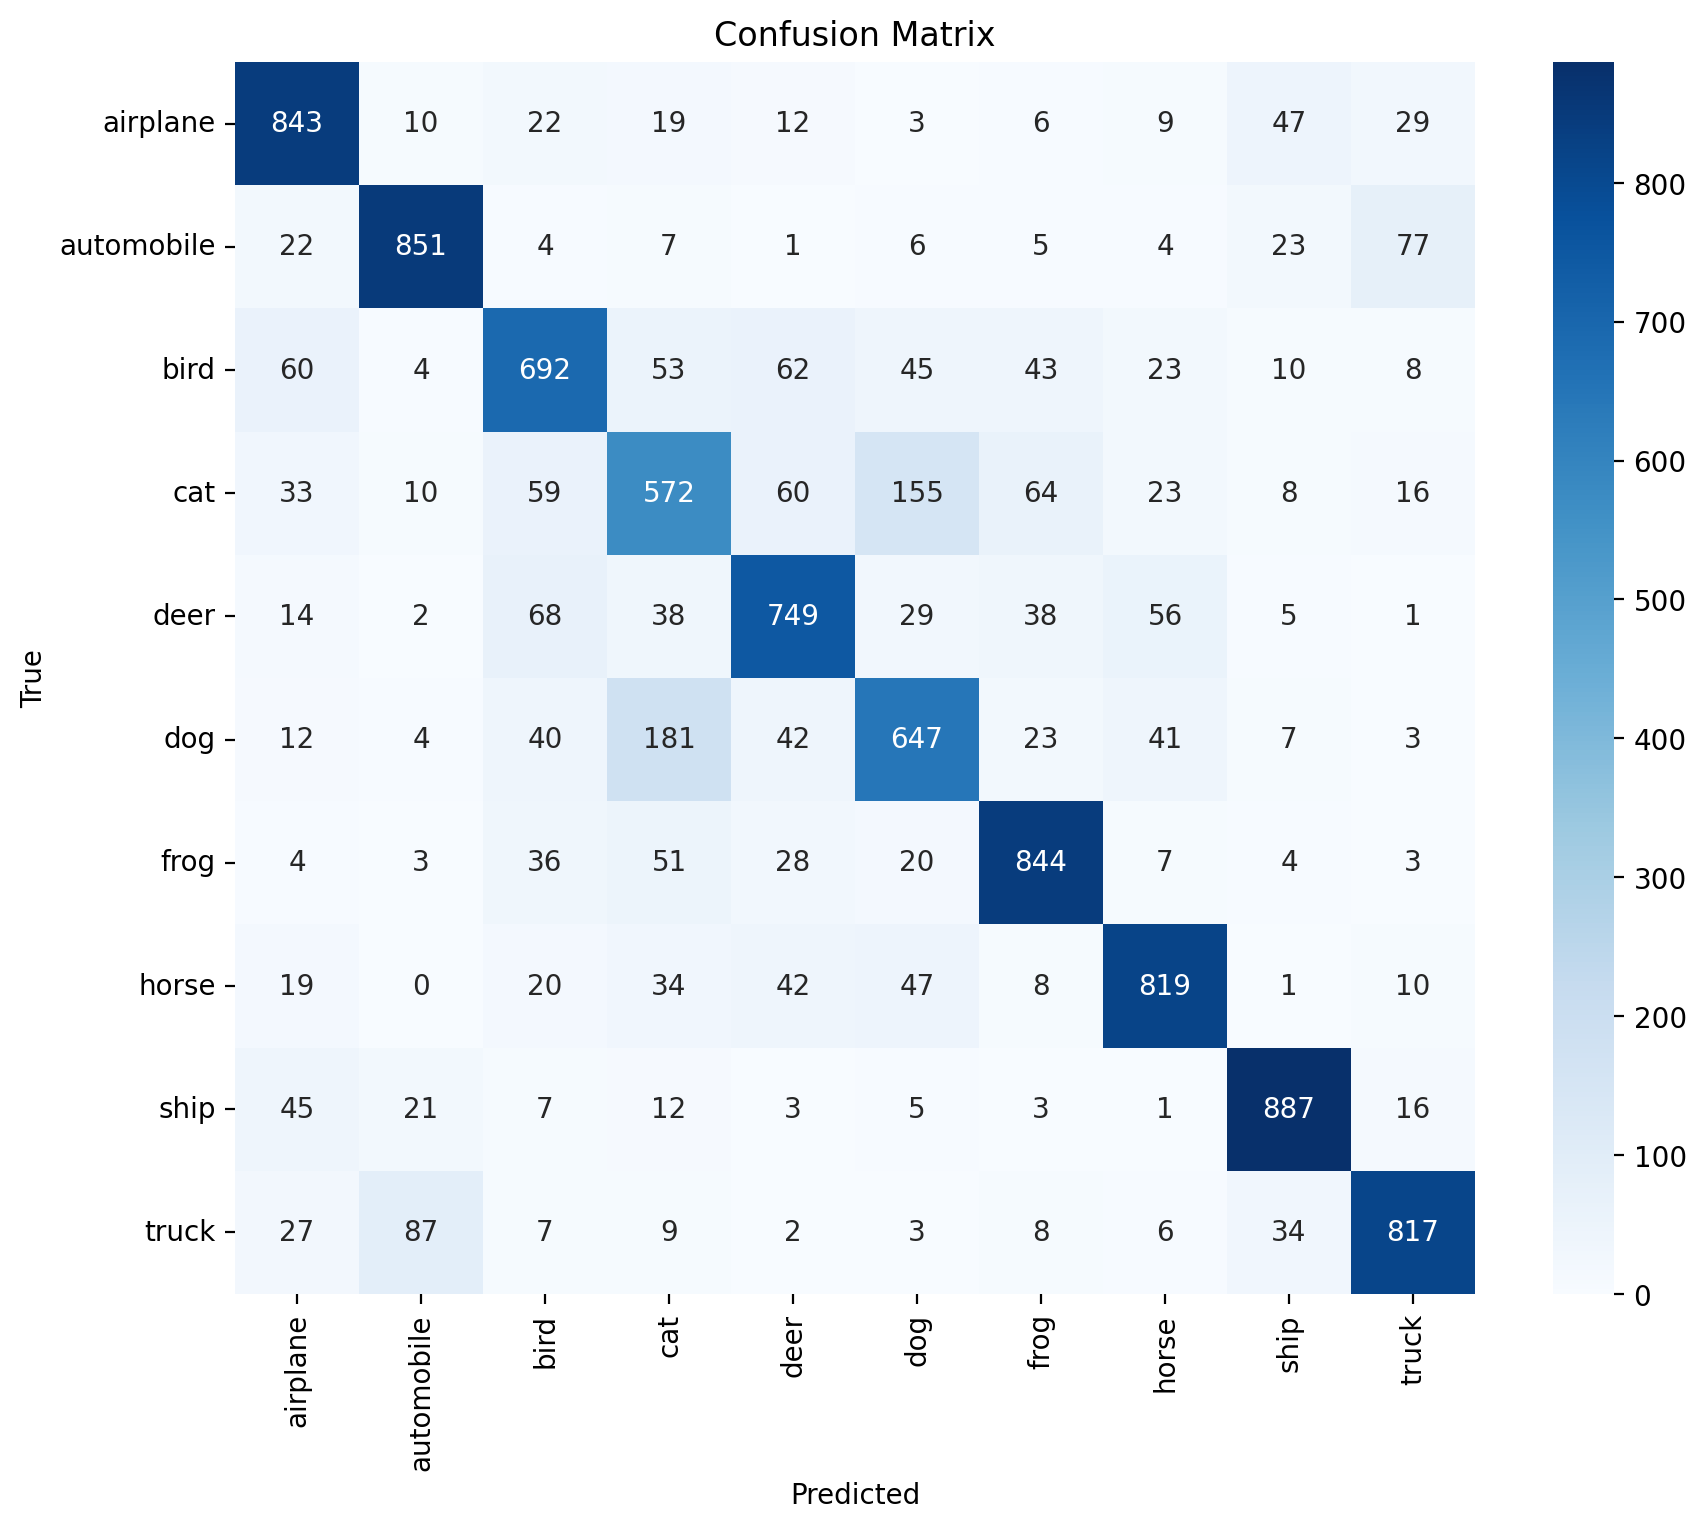

1/1 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

    airplane       0.78      0.84      0.81      1000
  automobile       0.86      0.85      0.85      1000
        bird       0.72      0.69      0.71      1000
         cat       0.59      0.57      0.58      1000
        deer       0.75      0.75      0.75      1000
         dog       0.67      0.65      0.66      1000
        frog       0.81      0.84      0.83      1000
       horse       0.83      0.82      0.82      1000
        ship       0.86      0.89      0.88      1000
       truck       0.83      0.82      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [ ]:
train_model('alexnet')